# Motion Estimation - TP n°1

### Le Guillouzic Maël

This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [10]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [11]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

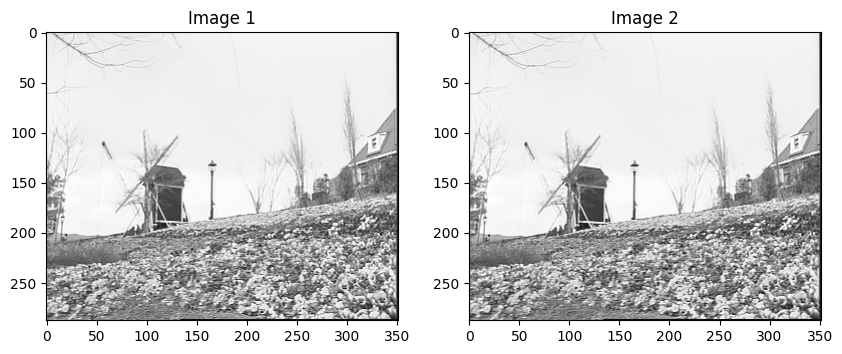

In [12]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im1, cmap='gray')
plt.title('Image 1')
plt.subplot(1,2,2)
plt.imshow(im2, cmap='gray')
plt.title('Image 2')
plt.show()

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [13]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [14]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

In [15]:
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo

    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of cols in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for i in range(0,np.shape(cur)[0]-brow+1,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for j in range(0,np.shape(cur)[1]-bcol+1,bcol):
                # current block selection
                B = cur[i:i+brow,j:j+bcol]

                # Initialization:
                costMin = np.inf
                Rbest = initVector(ref,cur)
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search+1): # rcol = candidate displacement vector over the rows
                        Bc = ref_extended[i+drow+extension:i+drow+extension+brow, j+dcol+extension:j+dcol+extension+bcol]
                        if np.shape(Bc) != np.shape(B):
                            print(f"Les blocs n'ont pas la meme taille. Taille de B (bloc de l'image current) : {np.shape(B)} et taille de Bc (bloc de l'image de reference) : {np.shape(Bc)}")
                            continue
                        cost = np.sum((B-Bc)**2) # SSD
                        if cost < costMin : # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = np.array([drow,dcol])
                            
                mvf[i:i+brow,j:j+bcol,0] = Rbest[0]
                mvf[i:i+brow,j:j+bcol,1] = Rbest[1]
                prediction[i:i+brow,j:j+bcol] = ref_extended[i+Rbest[0]+extension:i+Rbest[0]+extension+brow, j+Rbest[1]+extension:j+Rbest[1]+extension+bcol]
                
    else: # Regularized search
        print("Régularisation pas encore implémentée : à faire")
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [16]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

**Question :** Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?
Change the block size and the search area radius. How does it impact your results?

**Answer :** On observe que notre champ de vecteur est peu régulier dans les zones de "ciel" de l'image. Cela est surement du au fait que les zones sont très très similaires.

Essayons avec d'autres paramètres :
- bloc size = 8, 16 ou 32
- search radius = 8, 14, 20

On essaiera tout et on affiche tous les MVF

In [17]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')
    plt.quiver(X, Y, vectCol,-vectRow)
    plt.show()

    return

On affiche ci dessous le MVF pour une taille de bloc = 8 et un rayon search = 8


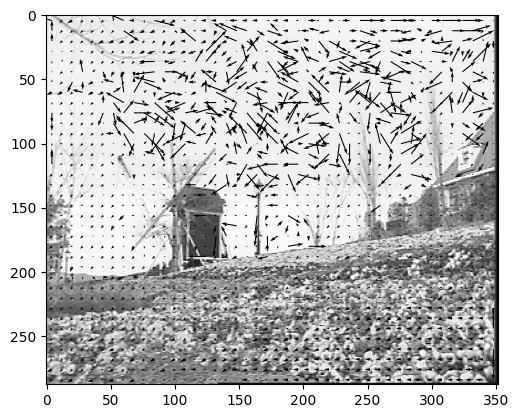

On affiche ci dessous le MVF pour une taille de bloc = 8 et un rayon search = 14


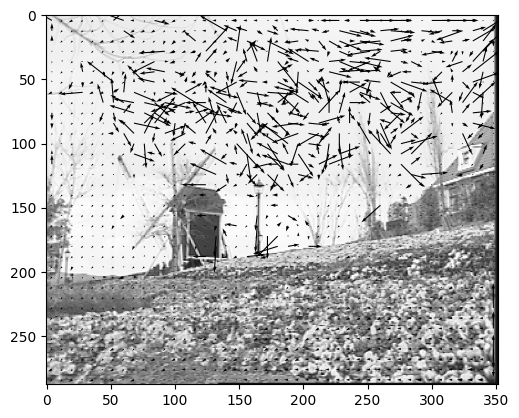

On affiche ci dessous le MVF pour une taille de bloc = 8 et un rayon search = 20


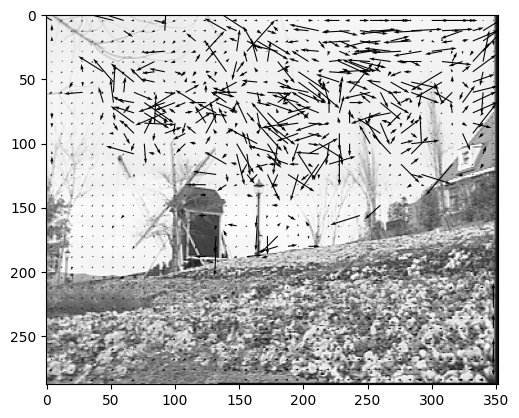

On affiche ci dessous le MVF pour une taille de bloc = 16 et un rayon search = 8


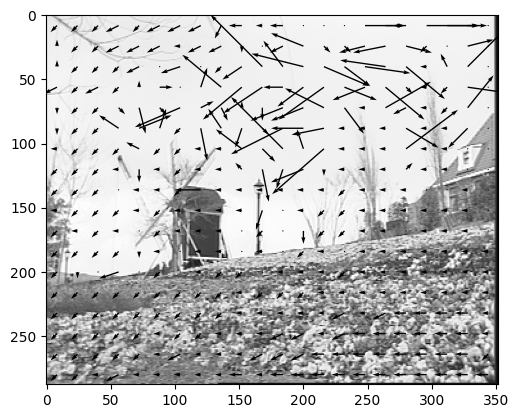

On affiche ci dessous le MVF pour une taille de bloc = 16 et un rayon search = 14


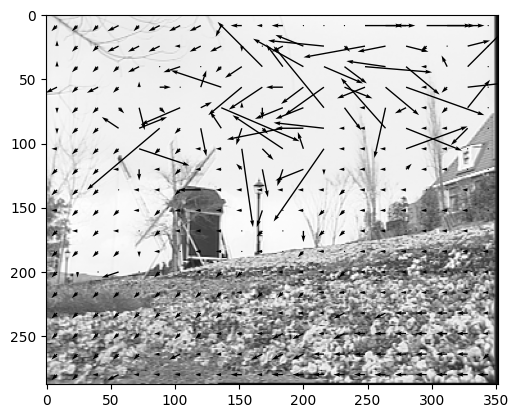

On affiche ci dessous le MVF pour une taille de bloc = 16 et un rayon search = 20


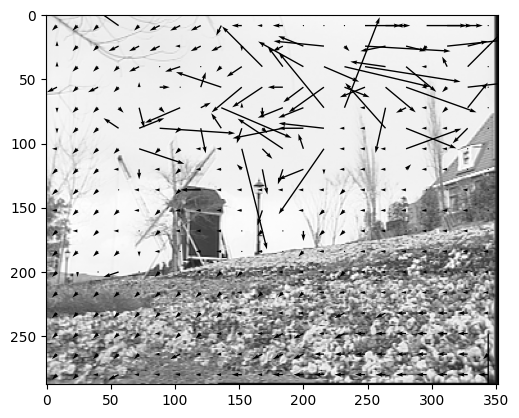

On affiche ci dessous le MVF pour une taille de bloc = 32 et un rayon search = 8


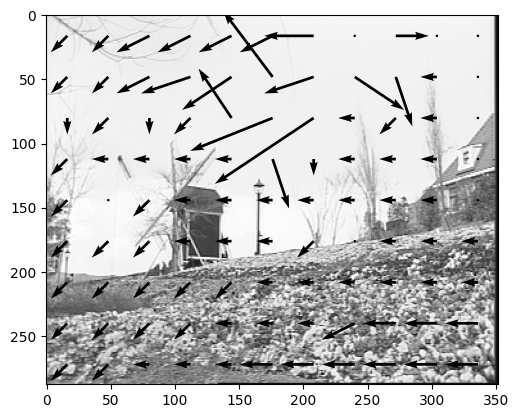

On affiche ci dessous le MVF pour une taille de bloc = 32 et un rayon search = 14


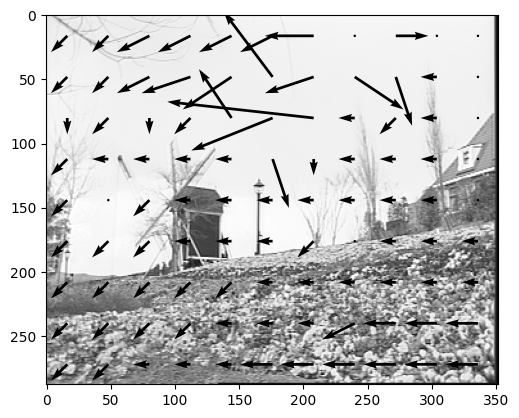

On affiche ci dessous le MVF pour une taille de bloc = 32 et un rayon search = 20


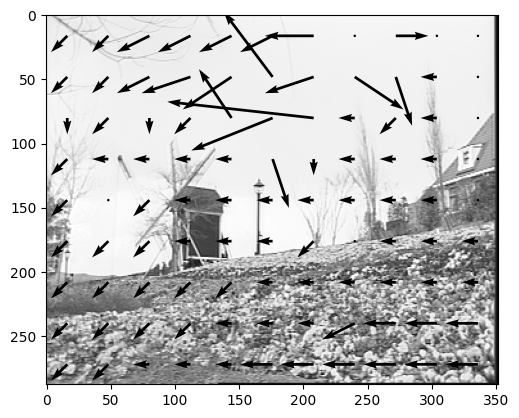

In [ ]:
# Essayons avec d'autres paramètres :
# - bloc size = 8, 16 ou 32
# - search radius = 8, 14, 20

# On essaiera tout et on affiche tous les MVF
bloc = [8,16,32]
search = [8,14,20]

for b in bloc:
    for s in search:
        mvf_ssd, pred = me_ssd(im2,im1,b,b,s)
        print(f"On affiche ci dessous le MVF pour une taille de bloc = {b} et un rayon search = {s}")
        displayMVF(im1,mvf_ssd,b)

On remarque que malgré des différences mineures, quelque soit le rayon de recherche et la taille des blocs on observe les mêmes défaults dans le ciel.

**Question :** Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

**Answer :** Les soucis dans le ciel au niveau du MVF causent quelques abérations dans l'image corrigée nottament sur le haut du lampadaire qui doit se situé en bordure de bloc et n'est donc pas traité "uniformément" (le bulbe du lampadaire est déplacé mais le chapeau ne suffit pas a faire déplacer tout son bloc).

In [18]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x12594f550>)

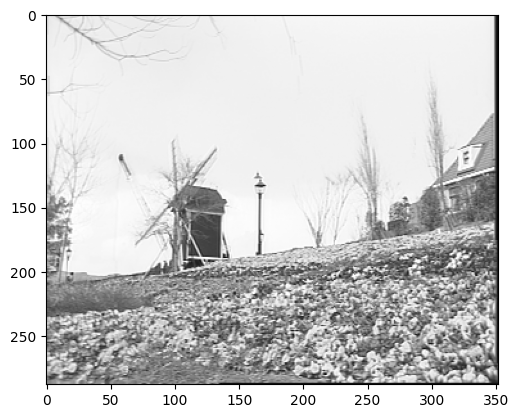

In [19]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

**Question :** Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

**Answer :** Le PSNR (Peak Signal-to-Noise Ratio) entre deux images $I$ et $K$ est défini par :
$$
PSNR = 10 \cdot \log_{10} \left(\frac{MAX^2}{MSE} \right)
$$
où la mean square error (MSE) est donnée par :
$$
MSE = \frac{1}{m \cdot n} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} \left( I(i,j) - K(i,j) \right)^2
$$
avec :
- $m, n$ les dimensions des images,
- $I(i,j)$ et $K(i,j)$ les valeurs des pixels aux coordonnées $(i, j)$,
- $MAX$ la valeur maximale d'un pixel.

Ainsi, commencons par regarder la plage de valeurs que prennent les pixels de nos images ainsi que leurs dimensions.

In [20]:
min = np.min(im1)
max = np.max(im1)
print(min,max)
(n1,m1) = im1.shape
print((n1,m1))

0.0 255.0
(288, 352)


On peut ainsi coder notre fonction PSNR avec $MAX=255$

In [21]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    if (im1.shape != im2.shape):
        raise ValueError("Les deux images doivent avoir la meme taille")
    MSE = np.mean((im1-im2)**2)
    if (MSE == 0):
        return float('inf')
    else :
        PSNR = 10*np.log10((255**2)/MSE)
    return PSNR
    

Désormais qu'on a une fonction pour calculer le PSNR, appliquons la à :
- im1 et im2 pour avoir une référence
- im2 et notre image compensée

Pour l'image compensée on essaiera avec plusieurs paramètres :
- $search = 8,14,16$
- $bloc size = 16,32$.

On fera les 6 combinaisons possibles et on cherchera le PSNR minimal.

In [ ]:
# On commence par calculer le PSNR entre im1 et im2
psnr_ref = PSNR(im1, im2)
print(f"Le PSNR entre im1 et im2 est de {psnr_ref} dB")

# On va maintenant chercher le PSNR minimal entre im2 et les images compensées
bloc = [16,32]
search = [8,14,16]
psnr = np.zeros((2,3))
for i,b in enumerate(bloc):
    for j,s in enumerate(search):
        mvf_ssd, prediction = me_ssd(im2,im1,b,b,s)
        mc_ssd = fracMc(im1,mvf_ssd)
        psnr[i,j] = PSNR(im2,mc_ssd)
        print(f"Pour un bloc size de {b} et un search radius de {s}, le PSNR est de {psnr[i,j]} dB")
        
# On cherche le PSNR minimal
min_psnr = np.min(psnr)
argmin = np.argmin(psnr)
bloc_min = bloc[argmin//3]
search_min = search[argmin%3]
print(f"Le PSNR minimal est de {min_psnr} dB pour un bloc size de {bloc_min} et un search radius de {search_min}")
        

Le PSNR entre im1 et im2 est de 18.786509322935075 dB
Pour un bloc size de 16 et un search radius de 8, le PSNR est de 16.460076383673186 dB
Pour un bloc size de 16 et un search radius de 14, le PSNR est de 16.45770448863718 dB
Pour un bloc size de 16 et un search radius de 16, le PSNR est de 16.458704686485987 dB
Pour un bloc size de 32 et un search radius de 8, le PSNR est de 16.347554902995817 dB
Pour un bloc size de 32 et un search radius de 14, le PSNR est de 16.347552970880223 dB
Pour un bloc size de 32 et un search radius de 16, le PSNR est de 16.347552970880223 dB
Le PSNR minimal est de 16.347552970880223 dB pour un bloc size de 32 et un search radius de 14


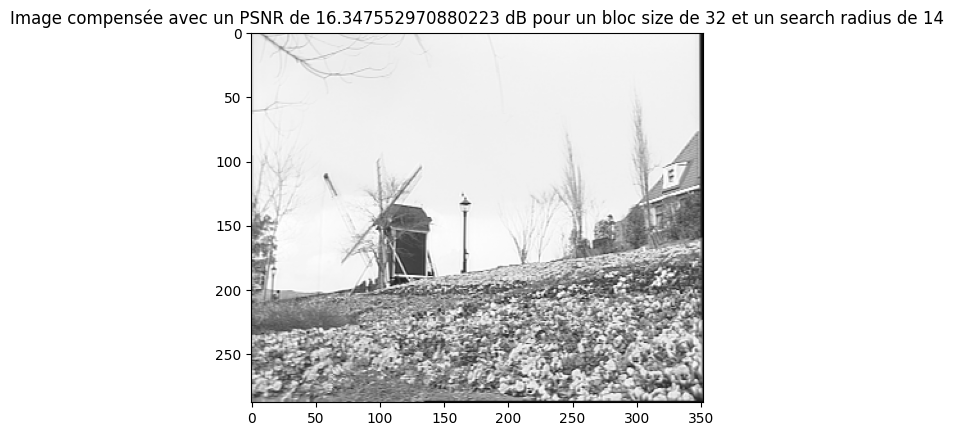

In [ ]:
# On affiche l'image correspondante
mvf_ssd, prediction = me_ssd(im2,im1,bloc_min,bloc_min,search_min)
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')
plt.title(f"Image compensée avec un PSNR de {min_psnr} dB pour un bloc size de {bloc_min} et un search radius de {search_min}")
plt.show()

### I-1-b Unregularized SAD-based algorithm

**Question :** Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

**Answer :** On a reprit quasiement en intégralité la fonction de la partie précédente, en modifiant uniquement le calcul de l'error et en remplacant la différence au carré par une valeur absolue.

In [22]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for i in range(0,np.shape(cur)[0]-brow+1,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for j in range(0,np.shape(cur)[1]-bcol+1,bcol):
                # current block selection
                B = cur[i:i+brow,j:j+bcol]

                # Initialization:
                costMin = np.inf
                Rbest = initVector(ref,cur)
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search+1): # rcol = candidate displacement vector over the rows
                        Bc = ref_extended[i+drow+extension:i+drow+extension+brow, j+dcol+extension:j+dcol+extension+bcol]
                        if np.shape(Bc) != np.shape(B):
                            print(f"Les blocs n'ont pas la meme taille. Taille de B (bloc de l'image current) : {np.shape(B)} et taille de Bc (bloc de l'image de reference) : {np.shape(Bc)}")
                            continue
                        cost = np.sum(np.abs(B-Bc)) # SSD
                        if cost < costMin : # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = np.array([drow,dcol])
                            
                mvf[i:i+brow,j:j+bcol,0] = Rbest[0]
                mvf[i:i+brow,j:j+bcol,1] = Rbest[1]
                prediction[i:i+brow,j:j+bcol] = ref_extended[i+Rbest[0]+extension:i+Rbest[0]+extension+brow, j+Rbest[1]+extension:j+Rbest[1]+extension+bcol]
                
    else: # Regularized search
        print("Régularisation pas encore implémentée : à faire")
        
        
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

**Question :** Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

**Answer :** On remarque que même si les abérations dans le ciel n'ont pas disparu, elles semblent plus réduite par rapport à celle présente dans le cas SSD. Cela pourrait faire penser que le SAD est plus résistant à ces problèmes, ce qui semblent cohérent avec le fait qu'une petite erreur est d'autant plus amplifiée par une mise au carré.

In [ ]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

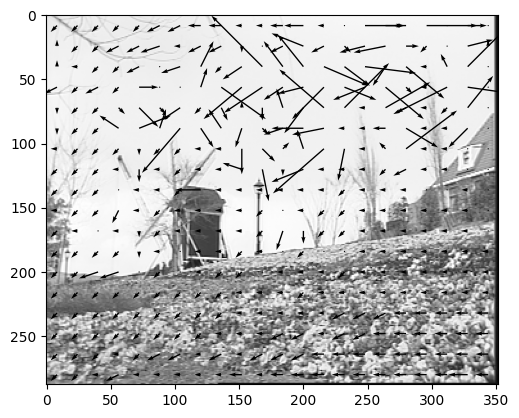

In [ ]:
displayMVF(im1,mvf_sad,brow)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1253f0f10>)

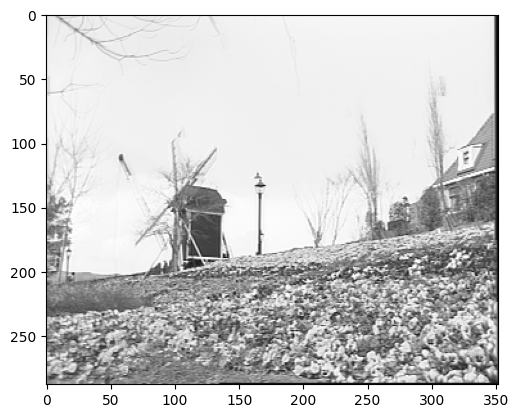

In [25]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

**Question :** Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

**Answer :** On va refaire notre recherche de PSNR minimal pour quelques valeurs de taille de bloc et de rayon de recherche. On comparera alors au PSNR du cas SSD.

In [30]:
# Le PSNR entre im1 et im2 n'as pas changé, ré affichons le 
psnr_ref = PSNR(im1, im2)
print(f"Le PSNR entre im1 et im2 est de {psnr_ref} dB")

# On va maintenant chercher le PSNR minimal entre im2 et les images compensées
bloc = [16,32]
search = [8,14,16]
psnr_sad = np.zeros((2,3))
for i,b in enumerate(bloc):
    for j,s in enumerate(search):
        mvf_sad, prediction_sad = me_sad(im2,im1,b,b,s)
        mc_sad = fracMc(im1,mvf_sad)
        psnr_sad[i,j] = PSNR(im2,mc_sad)
        print(f"Pour un bloc size de {b} et un search radius de {s}, le PSNR est de {psnr_sad[i,j]} dB")
        
# On cherche le PSNR minimal
min_psnr = np.min(psnr_sad)
argmin = np.argmin(psnr_sad)
bloc_min = bloc[argmin//3]
search_min = search[argmin%3]
print(f"Le PSNR minimal est de {min_psnr} dB pour un bloc size de {bloc_min} et un search radius de {search_min}")
        

Le PSNR entre im1 et im2 est de 18.786509322935075 dB
Pour un bloc size de 16 et un search radius de 8, le PSNR est de 16.39962998394595 dB
Pour un bloc size de 16 et un search radius de 14, le PSNR est de 16.39768500374325 dB
Pour un bloc size de 16 et un search radius de 16, le PSNR est de 16.391351027594602 dB
Pour un bloc size de 32 et un search radius de 8, le PSNR est de 16.331864409040907 dB
Pour un bloc size de 32 et un search radius de 14, le PSNR est de 16.331864409040907 dB
Pour un bloc size de 32 et un search radius de 16, le PSNR est de 16.331864409040907 dB
Le PSNR minimal est de 16.331864409040907 dB pour un bloc size de 32 et un search radius de 8


On affiche l'image correspondante, mais on remarque déja que le SAD présente un PSNR inférieur !

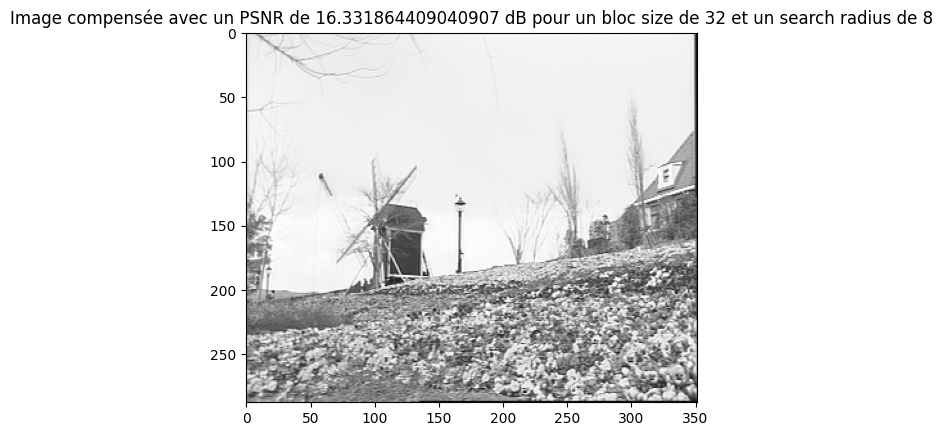

In [31]:
# On affiche l'image correspondante
mvf_sad, prediction_sad = me_sad(im2,im1,bloc_min,bloc_min,search_min)
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')
plt.title(f"Image compensée avec un PSNR de {min_psnr} dB pour un bloc size de {bloc_min} et un search radius de {search_min}")
plt.show()

## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

**Question :** : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

In [32]:
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo

    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of cols in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for i in range(0,np.shape(cur)[0]-brow+1,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for j in range(0,np.shape(cur)[1]-bcol+1,bcol):
                # current block selection
                B = cur[i:i+brow,j:j+bcol]

                # Initialization:
                costMin = np.inf
                Rbest = initVector(ref,cur)
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search+1): # rcol = candidate displacement vector over the rows
                        Bc = ref_extended[i+drow+extension:i+drow+extension+brow, j+dcol+extension:j+dcol+extension+bcol]
                        if np.shape(Bc) != np.shape(B):
                            print(f"Les blocs n'ont pas la meme taille. Taille de B (bloc de l'image current) : {np.shape(B)} et taille de Bc (bloc de l'image de reference) : {np.shape(Bc)}")
                            continue
                        cost = np.sum((B-Bc)**2) # SSD
                        if cost < costMin : # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = np.array([drow,dcol])
                            
                mvf[i:i+brow,j:j+bcol,0] = Rbest[0]
                mvf[i:i+brow,j:j+bcol,1] = Rbest[1]
                prediction[i:i+brow,j:j+bcol] = ref_extended[i+Rbest[0]+extension:i+Rbest[0]+extension+brow, j+Rbest[1]+extension:j+Rbest[1]+extension+bcol]
                
    else: # Regularized search
        for r in range(0,np.shape(cur)[0],brow) : # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0,np.shape(cur)[1],bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol]

                # Initializations          
                costMin = np.inf
                Rbest = initVector(ref,cur)
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search,search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search+1) : # rcol = candidate displacement vector over the rows
                        Bc = ref_extended[r+drow+extension:r+drow+extension+brow, c+dcol+extension:c+dcol+extension+bcol]
                        if np.shape(Bc) != np.shape(B):
                            print(f"Les blocs n'ont pas la meme taille. Taille de B (bloc de l'image current) : {np.shape(B)} et taille de Bc (bloc de l'image de reference) : {np.shape(Bc)}")
                            continue
                        cost = np.sum((B-Bc)**2) + lamb*np.sum((np.array([drow,dcol])-pV)**2)
                        if cost < costMin :
                            costMin = cost
                            Rbest = np.array([drow,dcol])
                
                
                mvf[r:r+brow,c:c+bcol,0]= Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= ref_extended[r+Rbest[0]+extension:r+Rbest[0]+extension+brow, c+Rbest[1]+extension:c+Rbest[1]+extension+bcol]
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

**Answer :** Pour l'image compensée on essaiera avec plusieurs paramètres :
- $lambda = 0$ et $search$ variant de 8 à 14 avec un pas de 2
- $lambda = brow*bcol$ et $search$ variant de 8 à 14 avec un pas de 2
- $lambda = sqrt(brow*bcol)$ et $search$ variant de 8 à 14 avec un pas de 2
- $lambda = 2*brow*bcol$ et $search$ variant de 8 à 14 avec un pas de 2

Pourquoi faire varier $search$ de 8 à 14 ? Car j'ai testé pour des valeurs inférieures à 8 et supérieures à 14 et le PSNR était constamment supérieur. Pour gagner en temps de calcul on évite donc de les calculer.

In [42]:
# Calculons, pour chaque couple de paramètres, le PSNR entre im2 et l'image compensée et enrigistrons les résultats (avec régularisation)
psnr = np.zeros((4,2))
lambdas = [0, 16*16, np.sqrt(16*16), 2*16*16]
search_values = [8,14]

for j, lamb in enumerate(lambdas):
    for i, search in enumerate(search_values):
        mvf_ssd, prediction = me_ssd(im2, im1,16,16, search, lamb=lamb)
        mc_ssd = fracMc(im1, mvf_ssd)
        psnr[j,i] = PSNR(im2, mc_ssd)
        print(f"Itérations terminées pour lambda = {lamb} et search = {search}, PSNR = {psnr[j,i]}")

# On cherche le PSNR minimal
min_psnr = np.min(psnr)
argmin = np.argmin(psnr)
lamb_min = lambdas[argmin // 4]
search_min = search_values[argmin%2]
print(f"Le PSNR minimal est de {min_psnr} dB pour un lambda de {lamb_min} et un search radius de {search_min}")

Itérations terminées pour lambda = 0 et search = 8, PSNR = 16.460076383673186
Itérations terminées pour lambda = 0 et search = 14, PSNR = 16.45770448863718
Itérations terminées pour lambda = 256 et search = 8, PSNR = 16.40094232852592
Itérations terminées pour lambda = 256 et search = 14, PSNR = 16.40094232852592
Itérations terminées pour lambda = 16.0 et search = 8, PSNR = 16.480708161350535
Itérations terminées pour lambda = 16.0 et search = 14, PSNR = 16.480708161350535
Itérations terminées pour lambda = 512 et search = 8, PSNR = 17.246922259753724
Itérations terminées pour lambda = 512 et search = 14, PSNR = 17.246922259753724
Le PSNR minimal est de 16.40094232852592 dB pour un lambda de 0 et un search radius de 8


Ce qui est étonnant, c'est qu'on obtient un PSNR supérieur a ce qu'on avait sans régularisation si on utilise une lambda régularisation. Soit il y a un probleme quelque part, soit je ne comprend pas pourquoi ...

Forcement l'image affichée est la meme que sans régularisation. Affichons en une qui soit régularisée pour au moins voir a quoi ca ressemble.

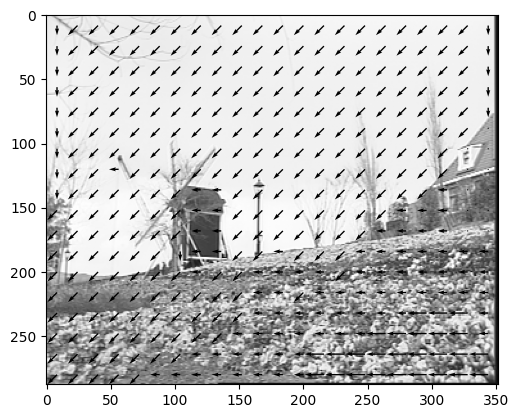

In [45]:
# Affichons le mvf correspondant
mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_min, lamb=256)
displayMVF(im1, mvf_ssd, brow)

### I-2-2- Regularized SAD-based algorithm

**Question :** : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

In [46]:
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_sad(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo

    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of cols in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for i in range(0,np.shape(cur)[0]-brow+1,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for j in range(0,np.shape(cur)[1]-bcol+1,bcol):
                # current block selection
                B = cur[i:i+brow,j:j+bcol]

                # Initialization:
                costMin = np.inf
                Rbest = initVector(ref,cur)
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search+1): # rcol = candidate displacement vector over the rows
                        Bc = ref_extended[i+drow+extension:i+drow+extension+brow, j+dcol+extension:j+dcol+extension+bcol]
                        if np.shape(Bc) != np.shape(B):
                            print(f"Les blocs n'ont pas la meme taille. Taille de B (bloc de l'image current) : {np.shape(B)} et taille de Bc (bloc de l'image de reference) : {np.shape(Bc)}")
                            continue
                        cost = np.sum(np.abs(B-Bc)) # SSD
                        if cost < costMin : # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = np.array([drow,dcol])
                            
                mvf[i:i+brow,j:j+bcol,0] = Rbest[0]
                mvf[i:i+brow,j:j+bcol,1] = Rbest[1]
                prediction[i:i+brow,j:j+bcol] = ref_extended[i+Rbest[0]+extension:i+Rbest[0]+extension+brow, j+Rbest[1]+extension:j+Rbest[1]+extension+bcol]
                
    else: # Regularized search
        for r in range(0,np.shape(cur)[0],brow) : # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0,np.shape(cur)[1],bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol]

                # Initializations          
                costMin = np.inf
                Rbest = initVector(ref,cur)
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search,search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search+1) : # rcol = candidate displacement vector over the rows
                        Bc = ref_extended[r+drow+extension:r+drow+extension+brow, c+dcol+extension:c+dcol+extension+bcol]
                        if np.shape(Bc) != np.shape(B):
                            print(f"Les blocs n'ont pas la meme taille. Taille de B (bloc de l'image current) : {np.shape(B)} et taille de Bc (bloc de l'image de reference) : {np.shape(Bc)}")
                            continue
                        cost = np.sum(np.abs(B-Bc)) + lamb*np.sum((np.array([drow,dcol])-pV)**2)
                        if cost < costMin :
                            costMin = cost
                            Rbest = np.array([drow,dcol])
                
                
                mvf[r:r+brow,c:c+bcol,0]= Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= ref_extended[r+Rbest[0]+extension:r+Rbest[0]+extension+brow, c+Rbest[1]+extension:c+Rbest[1]+extension+bcol]
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

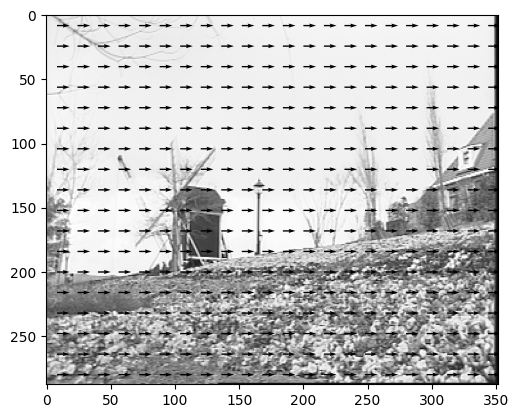

In [74]:
# Affichons le mvf correspondant
mvf_sad, prediction = me_sad(im2, im1, brow, bcol,14,lamb=256)
displayMVF(im1, mvf_sad, brow)

In [75]:
# Caculons le PSNR 
mc_sad = fracMc(im1, mvf_sad)
psnr_sad = PSNR(im2, mc_sad)
print(f"Le PSNR est de {psnr_sad} dB")

Le PSNR est de 21.14010816417288 dB


# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [59]:
im1_HS = loadmat('akiyo_cif1.mat')['im1']
im1_HS = im1_HS.astype('float')
im2_HS = loadmat('akiyo_cif2.mat')['im2']
im2_HS = im2_HS.astype('float')

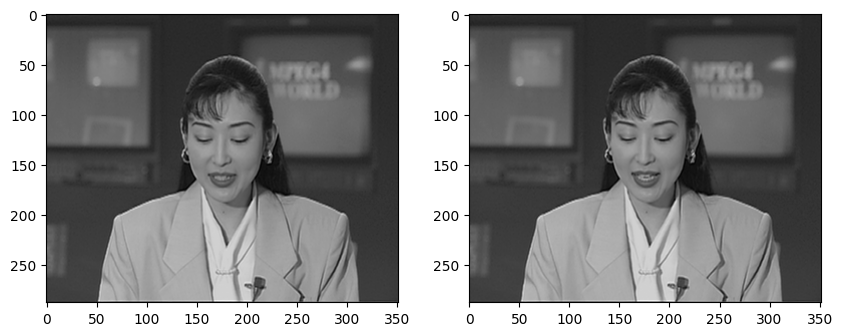

In [60]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im1_HS, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im2_HS, cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [61]:
brow = 16; bcol=16; search_radius =13

In [62]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = cv2.filter2D(u,-1,kernel_1)
        vAvg = cv2.filter2D(v,-1,kernel_1)
        
        num = (fx * uAvg + fy * vAvg + ft)
        denom = alpha**2 + fx**2 + fy**2
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx * num / denom
        v = vAvg - fy * num / denom
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [67]:
alpha = 100
ite = 100

# On utilise le flot optique estimé par Block Matching comme initialisation.
mvf_ssd_HS = me_ssd(im2_HS, im1_HS, 16, 16, 13)[0]

uInitial  = mvf_ssd_HS[:,:,1]
vInitial = mvf_ssd_HS[:,:,0]
[u, v] = HS(im2_HS, im1_HS, uInitial, vInitial, alpha, ite,blur=1.)

**Question :** Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

**Answer :** Quand on effectue HS sur l'image de la présentatrice, on remarque que le mvf est correctement focalisé sur le visage de la personne. Cela semble très logique !

Effectuons le sur l'image de la première partie, et calculons aussi le PSNR pour comparer.

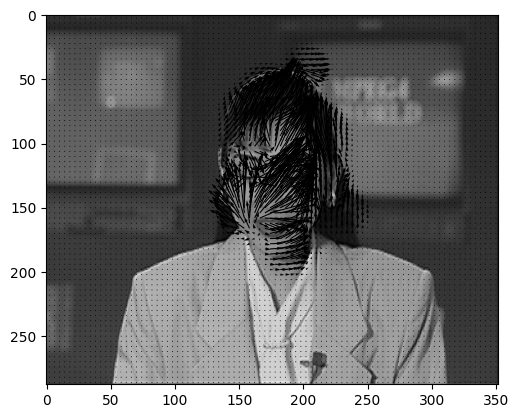

In [68]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1_HS,mvf_hs,4)

mc_hs = fracMc(im1_HS,mvf_hs)
psnr_hs = PSNR(im2_HS,mc_hs)

Calculons le PSNR de cette méthode.

In [70]:
print(f"Le PSNR entre im2 et l'image compensée par Horn-Schunck est de {psnr_hs} dB")

Le PSNR entre im2 et l'image compensée par Horn-Schunck est de 35.829191465988586 dB


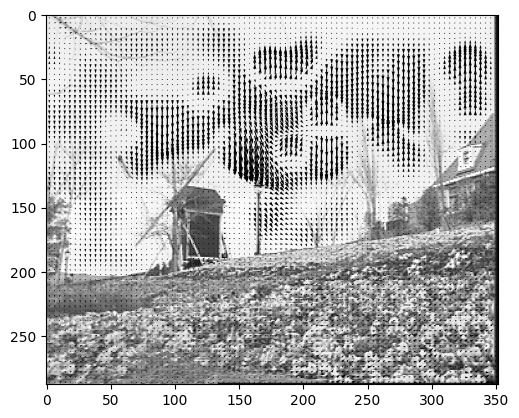

Le PSNR entre im2 et l'image compensée par Horn-Schunck est de 21.642541690809402 dB


In [ ]:
mvf_ssd = me_ssd(im2, im1, brow, bcol, 14)[0]

uItnitial = mvf_ssd[:,:,1]
vInitial = mvf_ssd[:,:,0]

[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

mvf_hs_flowers = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs_flowers[:,:,0] = v
mvf_hs_flowers[:,:,1] = u
displayMVF(im1, mvf_hs_flowers, 4)

mc_hs_flowers = fracMc(im1, mvf_hs_flowers)
psnr_hs_flowers = PSNR(im2,mc_hs_flowers)
print(f"Le PSNR entre im2 et l'image compensée par Horn-Schunck est de {psnr_hs_flowers} dB")

On remarque encore ces abérations dans le ciel avec HS.